In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from file_cache import *


In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [5]:

from file_cache import *

img_file_list = glob('/share/data2/body/brain/train_v2/image/*CT*/**/*.*', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})
df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
df.sort_values('p_id')

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

df['valid'] = df.p_id%5 ==1

df.valid.value_counts()

2020-06-12 13:52:34,811 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-06-12 13:52:34,812 utils.py[141] INFO NumExpr defaulting to 8 threads.


False    2060
True      551
Name: valid, dtype: int64

## Datasets

In [6]:
size =224
bs = 8
print('size, bs', size, bs)

size, bs 224 8


In [7]:
codes = range(5)

def get_y_fn(x):
    print(x)
    return x.replace('image', 'label')


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       #.label_from_func(get_y_fn, classes=codes)
       .label_from_df(cols='label_path', classes=codes)
      )
       #.label_from_func(cols='label_path', classes=codes))
    
print(len(src.train), len(src.valid))

#
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

2060 551


In [8]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [9]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([8, 3, 224, 224])

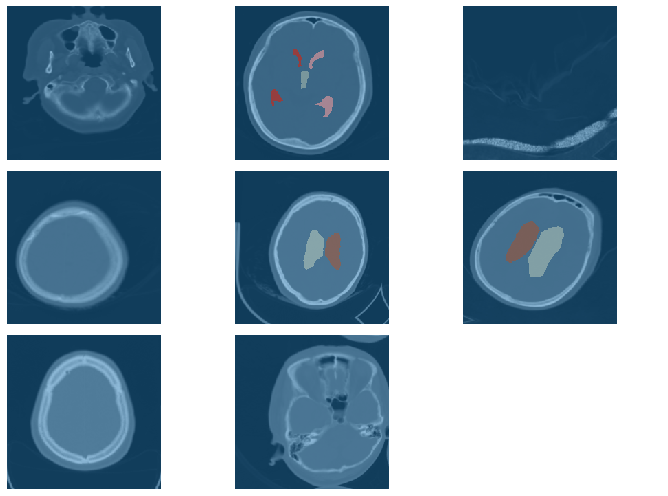

In [10]:
data.show_batch(4, figsize=(10, 7))

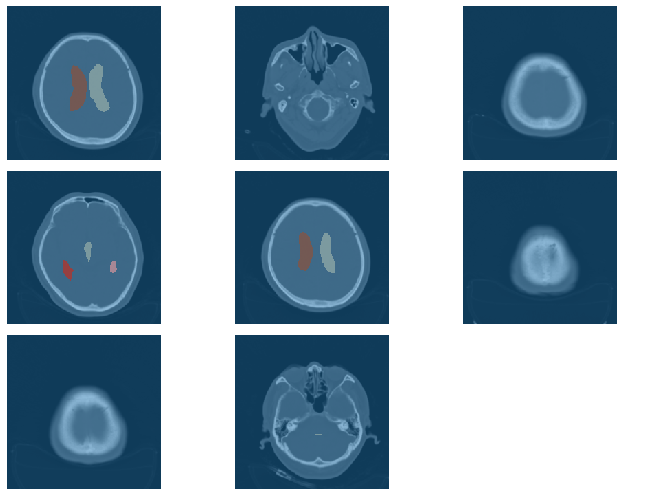

In [11]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [12]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [13]:
wd = 1e-2


In [14]:
print('abc')

abc


In [17]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in range(5) ] #, accuracy,

import ipdb
# ipdb.set_trace()
learn = unet_learner(data, models.densenet121(), metrics=metrics, wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not bool

In [ ]:
import torch
from torch import nn
from fastai.vision import models
from efficientnet_pytorch import EfficientNet

def eff():
    class EfficientNet_(EfficientNet):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
        def forward(self, inputs):
            x = self.extract_features(inputs)
            return x
    return EfficientNet_.from_pretrained(f'efficientnet-b0', in_channels=3)


for encoder in [eff(), 
                nn.Sequential(*list(models.resnet34().children())[:-3])]:
    unet =  models.unet.DynamicUnet(encoder, n_classes=5, img_size=(224, 224)) 

    print(type(encoder), unet(torch.rand(1,3,224,224)).shape)


 

In [3]:
from efficientnet_pytorch import EfficientNet


def eff(*args, **kwargs):
    class EfficientNet_(EfficientNet):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            
        def forward(self, inputs):
            bs = inputs.size(0)
            x = self.extract_features(inputs)
            return x
    name='0'
    return EfficientNet_.from_pretrained(f'efficientnet-b{name}', in_channels=3)



def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    learn = Learner(data, eff(), **learn_kwargs)
    return learn

unet_learner(data, eff, metrics=metrics, wd=wd)

NameError: name 'DataBunch' is not defined

In [20]:
os.path.abspath('./output/model')

'/share/felix/pj/brain_seg/output/model'

In [40]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


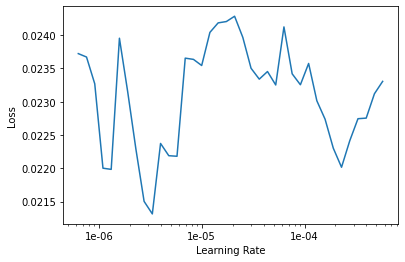

In [41]:
learn.recorder.plot()

In [42]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.020129,0.028499,0.997674,0.629807,0.691617,0.955044,0.930091,00:38
1,0.020409,0.028510,0.997482,0.662972,0.633091,0.953603,0.926470,00:38
2,0.019107,0.027606,0.997756,0.626127,0.758052,0.955759,0.936848,00:38
3,0.020007,0.029279,0.997680,0.552613,0.758427,0.946370,0.928218,00:39
4,0.020984,0.026215,0.997782,0.719944,0.724725,0.959179,0.930743,00:41


In [23]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.086518,0.060781,0.990171,0.550487,0.052915,0.437037,0.880787,00:40
1,0.045318,0.041534,0.994849,0.550144,0.682345,0.911755,0.880787,00:38
2,0.035870,0.052323,0.993234,0.671660,0.576248,0.911755,0.880787,00:38
3,0.031903,0.029961,0.996478,0.708989,0.744590,0.940366,0.921351,00:40
4,0.026022,0.027498,0.997212,0.639515,0.741132,0.944340,0.933437,00:41


In [24]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.022437,0.027550,0.997182,0.652600,0.718760,0.950986,0.928400,00:41
1,0.023294,0.027745,0.997247,0.705866,0.629451,0.953767,0.931851,00:42
2,0.025428,0.028983,0.997302,0.559627,0.697788,0.947723,0.929950,00:42
3,0.022471,0.025641,0.997485,0.622313,0.713699,0.934289,0.929325,00:42


KeyboardInterrupt: 

In [ ]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.show_results(DatasetType.Valid, rows=40)
